In [8]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance




np.random.seed(0)
scaler = MinMaxScaler()


def get_data(scaling):


    dataset = pd.read_csv("Data.csv")
    grouped = dataset.groupby('fire_record')
    labels = list(grouped.groups.keys())
    X_data = []
    y_data = []
    for label in labels:
        each_data = grouped.get_group(label)
        each_train_x = each_data.iloc[:, 1:].values[:600]
        each_train_y = each_data.iloc[:, 0].values[:600]
        for x in each_train_x:
            X_data.append(x)
        for y in each_train_y:
            y_data.append(y)

    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

    if scaling:
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

    feature_names = list(dataset.columns[1: ])
    return X_train, y_train, X_test, y_test, feature_names


def feature_imp(model, X_test, y_test, feature_names):
    r = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=0)
    for i in r.importances_mean.argsort()[::-1]:
     
        print(f"{feature_names[i]:<8}\t{r.importances_mean[i]:.3f} +/- {r.importances_std[i]:.3f}")


def build_classifier(method, X_train, y_train):
    if method == 'forest':
        cv_params = {'criterion': ['gini', 'entropy'], 'max_depth': [5, 10, 20], 'n_estimators': [100, 200, 300]}
        classifier = RandomForestClassifier(random_state=0)
    elif method == 'KNN':
        cv_params = {'n_neighbors': [3, 4, 5], 'weights': ['uniform', 'distance'], 'leaf_size': [20, 30, 40], 'p': [1, 2]}
        classifier = KNeighborsClassifier()
    elif method == 'logistic':
        cv_params = {'C': [0.1, 1, 10], 'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
        classifier = LogisticRegression(random_state=0, max_iter=500)
    gs = GridSearchCV(classifier, cv_params)
    gs.fit(X_train, y_train)
    print("Best parameters:", gs.best_params_)
    model = gs.best_estimator_
    model.fit(X_train, y_train)
    return model


def get_report(model, x_data, y_data):
    y_pred = model.predict(x_data)
    acc = metrics.accuracy_score(y_data, y_pred)
    report = metrics.classification_report(y_data, y_pred, digits=4)
    confusion = metrics.confusion_matrix(y_data, y_pred)
    return acc, report, confusion


if __name__ == '__main__':

    method = 'forest'
    if method in ['KNN', 'logistic']:
        scaling = True
    else:
        scaling = False
    X_train, y_train, X_test, y_test, feature_names = get_data(scaling)
    model = build_classifier(method, X_train, y_train)
    print('\n【Permutation feature importance】：')
    feature_imp(model, X_test, y_test, feature_names)
    print('\n')
    acc, report, confusion = get_report(model, X_test, y_test)
    print(f'【Method】：{method}')
    print(f'【Accuracy】：{acc}')
    print(f'【Report】：\n{report}')
    print(f'【Confusion matrix】：\n{confusion}')

Best parameters: {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}

【Permutation feature importance】：
population	0.019 +/- 0.018
other_ethnic_group	0.011 +/- 0.019
mixed/multiple_ethnic_groups	0.010 +/- 0.016
Black/African/Caribbean/Black British	-0.008 +/- 0.014
Asian/Asian_British	-0.011 +/- 0.012
Household_spaces_with_no_usual_residents	-0.017 +/- 0.013
Household_Median_Annual_Household_Income_estimate_2012	-0.023 +/- 0.018
White   	-0.026 +/- 0.013
IMD_score	-0.028 +/- 0.013


【Method】：forest
【Accuracy】：0.6541666666666667
【Report】：
              precision    recall  f1-score   support

           0     0.6000    0.7364    0.6612       110
           1     0.7238    0.5846    0.6468       130

    accuracy                         0.6542       240
   macro avg     0.6619    0.6605    0.6540       240
weighted avg     0.6671    0.6542    0.6534       240

【Confusion matrix】：
[[81 29]
 [54 76]]


In [10]:
def plot_confusion_matrix(cm, labels_name):
    sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, cbar=True)



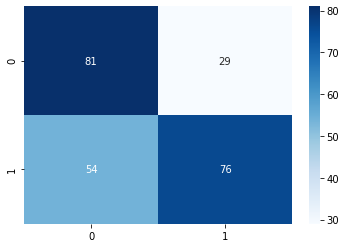

In [11]:
plot_confusion_matrix(confusion, [0, 1])